# Bernoulli GLM on example code

## Fit GLM-HMM to data from each individual IBL animals.

In [6]:
""" 
IMPORTS
"""
import os
import sys
import autograd.numpy as np

from glm_hmm_utils_dynamax import load_cluster_arr, load_session_fold_lookup, \
    load_animal_list, load_data, create_violation_mask

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import BernoulliHMM

In [13]:
from functools import partial
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
from pprint import pprint

from dynamax.hidden_markov_model import BernoulliHMM

In [14]:
""" 
SOME FUNCTIONS 
"""

def find_permutation(z1, z2):
    K1 = z1.max() + 1
    K2 = z2.max() + 1

    perm = []
    for k1 in range(K1):
        indices = jnp.where(z1 == k1)[0]
        counts = jnp.bincount(z2[indices])
        perm.append(jnp.argmax(counts))

    return jnp.array(perm)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (10, 5)
    if is_latexify_enabled():
        figsize = None
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_posterior_states(Ez, states, perm):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (25, 5)
    if is_latexify_enabled():
        figsize = None
    plt.figure(figsize=figsize)
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State", linewidth=1)
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")

In [31]:
num_states = 2
emission_dim = 1  # How can this be?


## True model

In [32]:
# True model
true_hmm = BernoulliHMM(num_states, emission_dim, 
                        emission_prior_concentration0=1.0, 
                        emission_prior_concentration1=1.0)
initial_probs = jnp.ones((num_states,)) / (num_states * 1.0)
transition_matrix = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states
true_params, _ = true_hmm.initialize(key=jr.PRNGKey(0), initial_probs=initial_probs, transition_matrix=transition_matrix)
pprint(true_params)

ParamsBernoulliHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.5, 0.5], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.95, 0.05],
       [0.05, 0.95]], dtype=float32)), emissions=ParamsBernoulliHMMEmissions(probs=Array([[0.4496428 ],
       [0.17260975]], dtype=float32)))


## Test model

In [78]:
test_hmm = BernoulliHMM(num_states, emission_dim)
params, props = test_hmm.initialize(key=jr.PRNGKey(1))
params, lps = test_hmm.fit_em(params, props, y[0:100])

Text(0, 0.5, 'log likelihood')

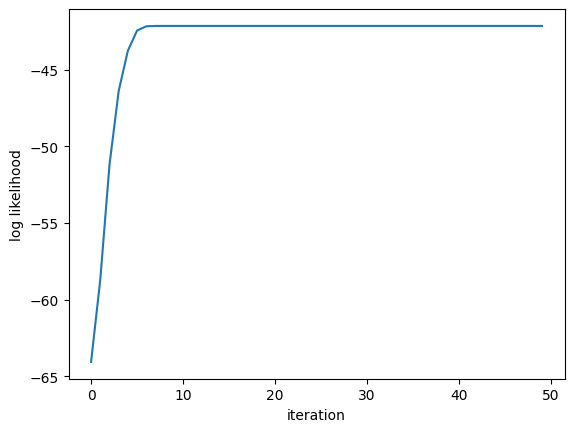

In [79]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

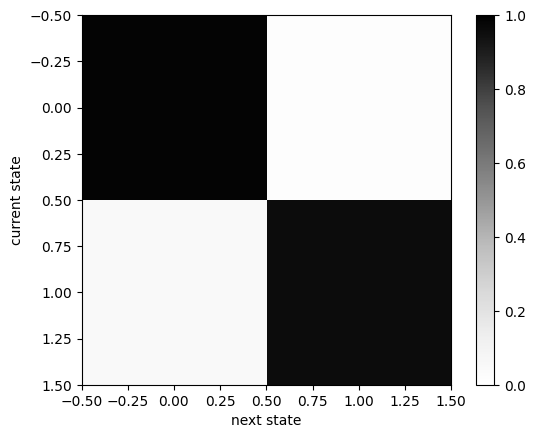

Array([[0.9819441 , 0.01805598],
       [0.04320101, 0.956799  ]], dtype=float32)

In [80]:
plot_transition_matrix(params[1].transition_matrix)
params[1].transition_matrix

In [81]:
# Posterior distribution
posterior = test_hmm.smoother(params, y[0:100])
Ez = posterior.smoothed_probs

In [82]:
Ez

Array([[3.2893766e-04, 9.9967104e-01],
       [2.1938876e-04, 9.9978060e-01],
       [2.1648094e-04, 9.9978358e-01],
       [3.0776588e-04, 9.9969226e-01],
       [8.8403031e-04, 9.9911594e-01],
       [4.4122371e-03, 9.9558771e-01],
       [2.5996482e-02, 9.7400349e-01],
       [1.5803796e-01, 8.4196204e-01],
       [9.6580034e-01, 3.4199595e-02],
       [9.9857718e-01, 1.4228679e-03],
       [9.9990714e-01, 9.2880386e-05],
       [9.9996108e-01, 3.8913222e-05],
       [9.9996328e-01, 3.6723406e-05],
       [9.9996334e-01, 3.6635123e-05],
       [9.9996334e-01, 3.6645677e-05],
       [9.9996299e-01, 3.6994523e-05],
       [9.9995440e-01, 4.5595239e-05],
       [9.9974245e-01, 2.5755481e-04],
       [9.9451882e-01, 5.4811686e-03],
       [9.9974245e-01, 2.5755487e-04],
       [9.9995440e-01, 4.5595454e-05],
       [9.9996299e-01, 3.6998659e-05],
       [9.9996328e-01, 3.6746624e-05],
       [9.9996090e-01, 3.9121893e-05],
       [9.9990201e-01, 9.8007309e-05],
       [9.9845076e-01, 1.

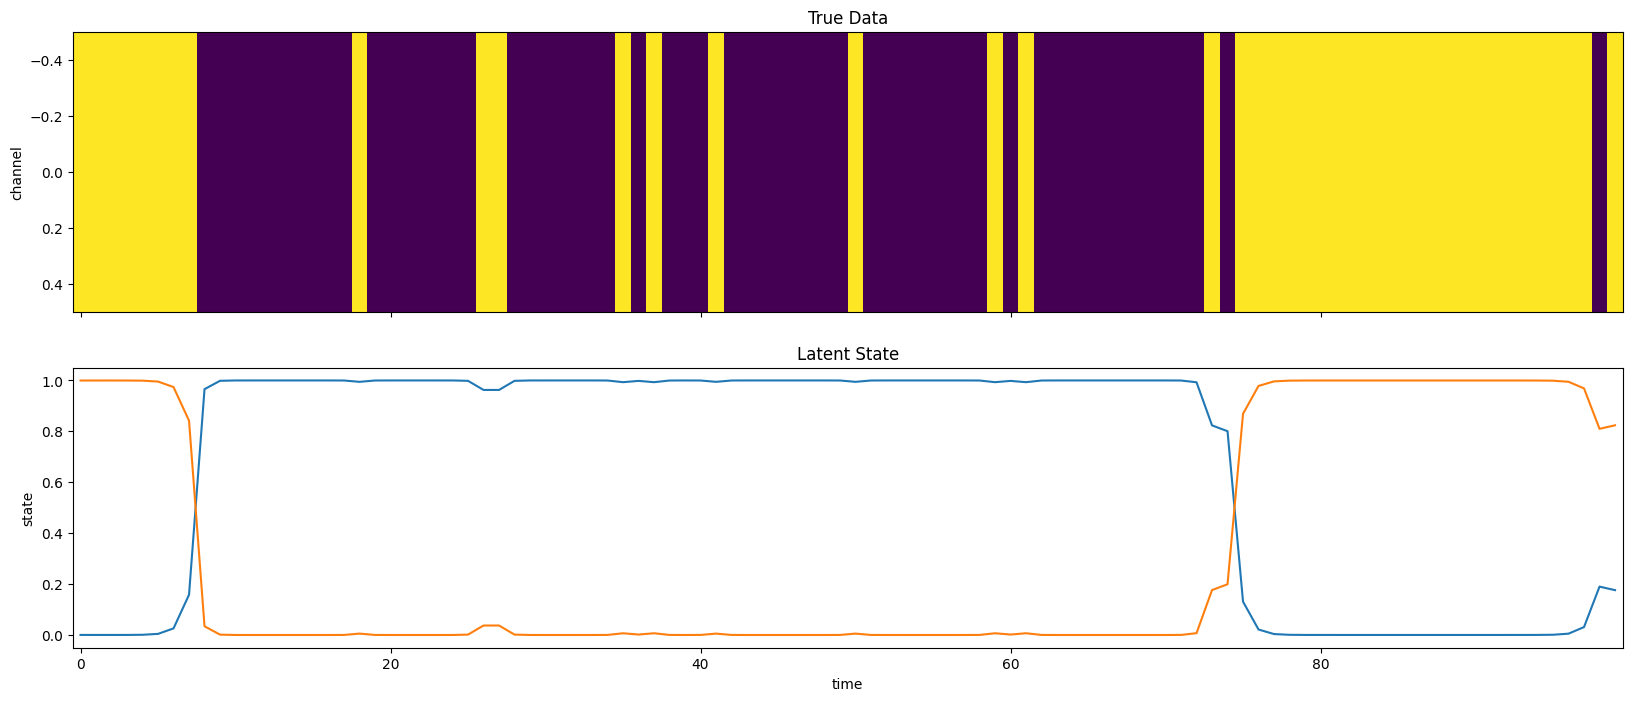

In [83]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(y[0:100].T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("True Data")
axs[1].plot(Ez)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()



In [84]:
y[0:100]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [38]:

# Posterior distribution
posterior = test_hmm.smoother(params, y)
Ez = posterior.smoothed_probs
perm = find_permutation(true_states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez, true_states, perm)



NameError: name 'emissions' is not defined

In [ ]:


# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    posterior = test_hmm.smoother(params, y[trial_idx])
    Ez = posterior.smoothed_probs
    states = all_true_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)



In [7]:
""" 
DIRECTORIES 
"""
results_dir = '/home/ines/repositories/representation_learning_variability/DATA/Dynamax/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

data_dir = '/home/ines/repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
#data_dir = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
processed_ibl_data_path = data_dir + "data_by_animal/"


In [8]:
""" 
PARAMETERS
"""
D = 1  # data (observations) dimension
C = 2  # number of output types/categories
K = 2
prior_sigma = [2]
transition_alpha = [2]
n_folds = 2
n_iter = 1
N_em_iters = 300  # number of EM iterations


In [67]:
animal = 'CSHL_001'
animal_file = processed_ibl_data_path + animal + '_processed.npz'
for f, fold in enumerate(range(n_folds)):
    for i, iter in enumerate(range(n_iter)):
        if os.path.exists(animal_file):
            
            session_fold_lookup_table = load_session_fold_lookup(
                processed_ibl_data_path + animal + '_session_fold_lookup.npz')

            inpt, y, session = load_data(animal_file)
            #  append a column of ones to inpt to represent the bias covariate:
            inpt = np.hstack((inpt, np.ones((len(inpt), 1))))
            y = y.astype('int')

            # Identify violations for exclusion:
            violation_idx = np.where(y == -1)[0]
            nonviolation_idx, mask = create_violation_mask(violation_idx,
                                                        inpt.shape[0])

            # TODO: init_param_file = ???

            # create save directory for this initialization/fold combination:
            save_directory = results_dir + animal + '/GLM_HMM_K_' + str(
                K) + '/' + 'fold_' + str(fold) + '/' + '/iter_' + str(iter) + '/'
            if not os.path.exists(save_directory):
                os.makedirs(save_directory)




In [12]:
key = jr.PRNGKey(0)
em_params, em_param_props = hmm.initialize(key)
em_params, log_probs = hmm.fit_em(em_params, 
                                  em_param_props, 
                                  batch_emissions, 
                                  num_iters=400)


NameError: name 'hmm' is not defined

In [ ]:
            launch_glm_hmm_job(inpt, y, session, mask, session_fold_lookup_table,
                            K, D, C, N_em_iters, transition_alpha, prior_sigma,
                            fold, iter, global_fit, init_param_file,
                            save_directory)

In [ ]:
animal = 'DY_014'
animal_file = processed_ibl_data_path + animal + '_processed.npz'
if os.path.exists(animal_file):
    
    bin_fold_lookup_table = load_session_fold_lookup(
        processed_ibl_data_path + animal + '_' + str(bin+1)+ '_bin_fold_lookup.npz')

    global_fit = False

    inpt, y, session = load_data(animal_file)
    #  append a column of ones to inpt to represent the bias covariate:
    inpt = np.hstack((inpt, np.ones((len(inpt), 1))))
    y = y.astype('int')

    overall_dir = results_dir + animal + '_' + str(bin+1) + '/'

    # Identify violations for exclusion:
    violation_idx = np.where(y == -1)[0]
    nonviolation_idx, mask = create_violation_mask(violation_idx,
                                                inpt.shape[0])

    init_param_file = processed_ibl_data_path + '/best_global_params' + \
                    '/GLM_HMM_K_' + str(K) + 'bin_' + str(bin+1) + \
                    '/best_params_K_' + \
                            str(K) + '.npz'

    # create save directory for this initialization/fold combination:
    save_directory = overall_dir + '/GLM_HMM_K_' + str(
        K) + '/' + 'fold_' + str(fold) + '/' + '/iter_' + str(iter) + '/'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    launch_glm_hmm_job(inpt, y, session, mask, bin_fold_lookup_table,
                    K, D, C, N_em_iters, transition_alpha, prior_sigma,
                    fold, iter, global_fit, init_param_file,
                    save_directory)

In [ ]:
#  In order to facilitate parallelization of jobs, create a job array that
#  can be used on e.g. a cluster
import numpy as np

prior_sigma = [2]
transition_alpha = [2]
K_vals = [2, 3]
num_folds = 5
N_initializations = 20

if __name__ == '__main__':
    cluster_job_arr = []
    for K in K_vals:
        for i in range(num_folds):
            for j in range(N_initializations):
                for sigma in prior_sigma:
                    for alpha in transition_alpha:
                        cluster_job_arr.append([sigma, alpha, K, i, j])
    np.savez(processed_ibl_data_path + 'cluster_job_arr_individual'
             '.npz',
             cluster_job_arr)
    print(len(cluster_job_arr))


200


In [ ]:

# Load external files:
cluster_arr_file = processed_ibl_data_path + 'cluster_job_arr_individual.npz'
# Load cluster array job parameters:
cluster_arr = load_cluster_arr(cluster_arr_file)

for m, model in enumerate(range(len(cluster_arr))):

    [prior_sigma, transition_alpha, K, fold, iter] = cluster_arr[m]
    iter = int(iter)
    fold = int(fold)
    K = int(K)

    animal_list = load_animal_list(processed_ibl_data_path + 'animal_list.npz')
    animal_list = ['DY_013', 'DY_012']
    
    bin_values = [0, 5, 9]

    # Loop through bins and fit a separate global GLM for each bin
    for b, bin in enumerate(bin_values):

        for i, animal in enumerate(animal_list):
            print(animal)

            animal_file = processed_ibl_data_path + animal + '_bin_' + str(bin+1) + '_processed.npz'
            if os.path.exists(animal_file):
                
                bin_fold_lookup_table = load_session_fold_lookup(
                    processed_ibl_data_path + animal + '_' + str(bin+1)+ '_bin_fold_lookup.npz')

                global_fit = False

                inpt, y, session = load_data(animal_file)
                #  append a column of ones to inpt to represent the bias covariate:
                inpt = np.hstack((inpt, np.ones((len(inpt), 1))))
                y = y.astype('int')

                overall_dir = results_dir + animal + '_' + str(bin+1) + '/'

                # Identify violations for exclusion:
                violation_idx = np.where(y == -1)[0]
                nonviolation_idx, mask = create_violation_mask(violation_idx,
                                                            inpt.shape[0])

                init_param_file = processed_ibl_data_path + '/best_global_params' + \
                                '/GLM_HMM_K_' + str(K) + 'bin_' + str(bin+1) + \
                                '/best_params_K_' + \
                                        str(K) + '.npz'

                # create save directory for this initialization/fold combination:
                save_directory = overall_dir + '/GLM_HMM_K_' + str(
                    K) + '/' + 'fold_' + str(fold) + '/' + '/iter_' + str(iter) + '/'
                if not os.path.exists(save_directory):
                    os.makedirs(save_directory)

                launch_glm_hmm_job(inpt, y, session, mask, bin_fold_lookup_table,
                                K, D, C, N_em_iters, transition_alpha, prior_sigma,
                                fold, iter, global_fit, init_param_file,
                                save_directory)


DY_013
Starting inference with K = 2; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 2; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 2; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 0; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 1; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 2; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 3; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 0
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 1
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 2
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 3
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 4
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 5
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 6
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 7
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 8
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 9
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 10
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 11
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 12
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 13
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 14
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 15
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 16
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 17
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 18
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_013
Starting inference with K = 3; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]

DY_012
Starting inference with K = 3; Fold = 4; Iter = 19
=== fitting GLM-HMM ========


  0%|          | 0/300 [00:00<?, ?it/s]